In [53]:
import pandas as pd

Pull down raw data

In [80]:
abalone_headers = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight',  'Rings']  
abalone_raw = pd.read_csv('../data/abalone-data/abalone.csv', names=abalone_headers)

wine_quality_red_raw = pd.read_csv('../data/winequality-data/winequality-red.csv', sep=';')
wine_quality_white_raw = pd.read_csv('../data/winequality-data/winequality-white.csv', sep=';')
wine_quality_white_raw['color'] = 1
wine_quality_red_raw['color'] = 0
wine_quality_raw = pd.concat([wine_quality_white_raw, wine_quality_red_raw])

forest_fires_raw = pd.read_csv('../data/forest+fires/forestfires.csv')



Process data

In [81]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# encode categorical data within abalone data set to be able to use it in models
abalone_sex_encoder = LabelEncoder()
abalone_raw['Sex'] = abalone_sex_encoder.fit_transform(abalone_raw['Sex'])

# encode categorical data within forest fires data set to be able to use it in models
forest_fires_month_encoder = LabelEncoder()
forest_fires_raw['month'] = forest_fires_month_encoder.fit_transform(forest_fires_raw['month'])

forest_fires_day_encoder = LabelEncoder()
forest_fires_raw['day'] = forest_fires_day_encoder.fit_transform(forest_fires_raw['day'])


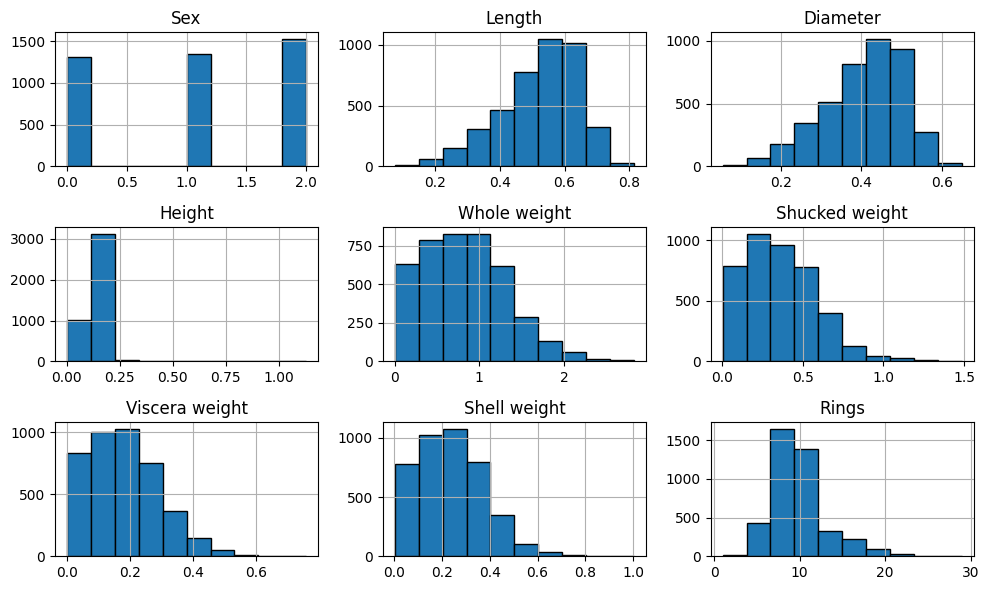

In [57]:
import matplotlib.pyplot as plt

abalone_raw.hist(figsize=(10, 6), bins=10, edgecolor='black')
plt.tight_layout()
plt.show()

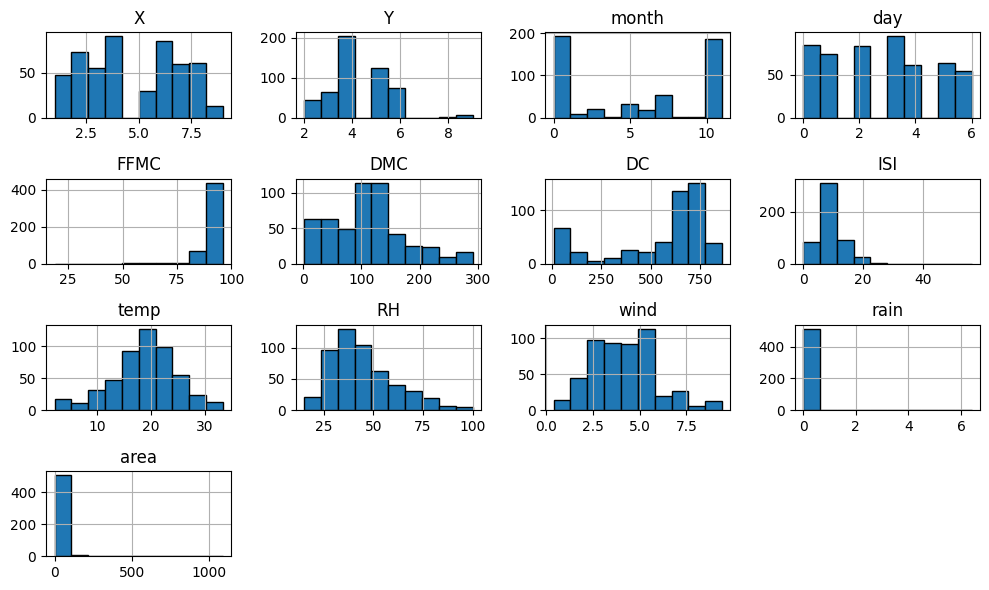

In [23]:
forest_fires_raw.hist(figsize=(10, 6), bins=10, edgecolor='black')
plt.tight_layout()
plt.show()

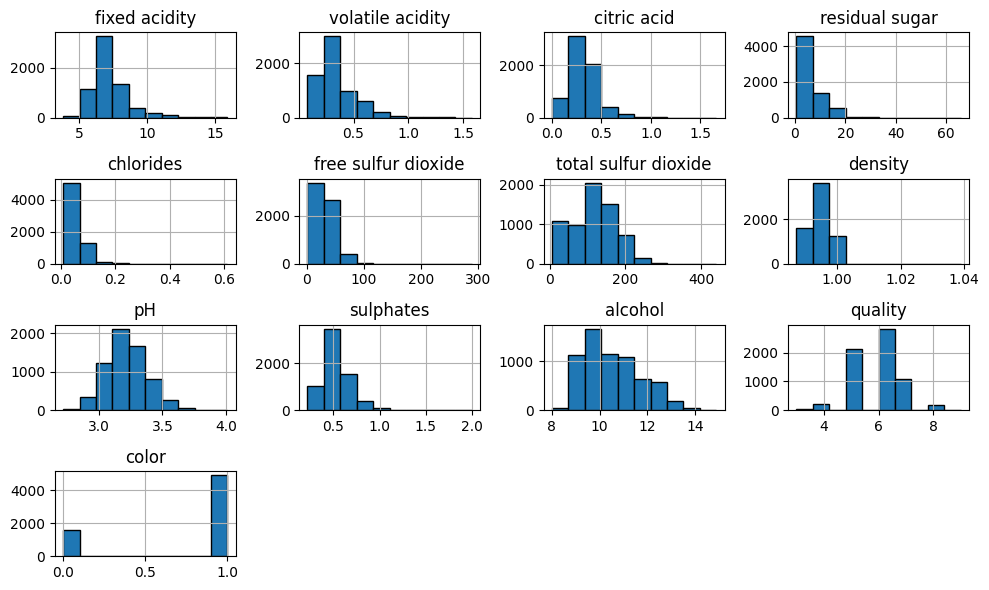

In [24]:
wine_quality_raw.hist(figsize=(10, 6), bins=10, edgecolor='black')
plt.tight_layout()
plt.show()

In [ ]:
# After observing a histogram of the different attributes for abalone, forestfires, and winequality 
# it is apparent that there will be a need to normalize the data since the attributes are on different orders of magnitudes

abalone_scaler = StandardScaler()
abalone_features = abalone_raw.drop(columns=['Rings'])
normalized_abalone_data = abalone_scaler.fit_transform(abalone_features)
normalized_abalone_data = pd.DataFrame(normalized_abalone_data, columns=abalone_features.columns, index=abalone_features.index)
normalized_abalone_data['Rings'] = abalone_raw['Rings'] # do not transform response variable

wine_scaler = StandardScaler()
wine_features = wine_quality_raw.drop(columns=['quality'])
normalized_winequality_data = wine_scaler.fit_transform(wine_features)
normalized_winequality_data = pd.DataFrame(normalized_winequality_data, columns=wine_features.columns, index=wine_features.index)
normalized_winequality_data['quality'] = wine_quality_raw['quality']  # do not transform response variable

# apply log transformation to help with a bunch of zeros and outliers
forestfires_scaler = StandardScaler()
forestfires_features = forest_fires_raw.drop(columns=['area'])
# Apply log(1+x) transformation on the features to avoid issues with zeros
# forestfires_features_transformed = forestfires_features.apply(lambda x: np.log1p(x))
normalized_forestfires_data = forestfires_scaler.fit_transform(forestfires_features)
normalized_forestfires_data = pd.DataFrame(normalized_forestfires_data, columns=forestfires_features.columns, index=forestfires_features.index)
normalized_forestfires_data['area'] = forest_fires_raw['area']  # do not transform response variable

In [92]:
# split data into test and train split 80/20
from sklearn.model_selection import train_test_split

#split data into test train 80/20 split - with random state set to 42 to allow for reprudicibility 
y_wine_qualtiy = normalized_winequality_data['quality'].to_numpy()
X_wine_quality = normalized_winequality_data.loc[:, normalized_winequality_data.columns != 'quality'].to_numpy()
X_wq_train, X_wq_test, y_wq_train, y_wq_test = train_test_split(X_wine_quality, y_wine_qualtiy, random_state=42, test_size=0.20)

y_abalone = normalized_abalone_data['Rings'].to_numpy()
X_abalone = normalized_abalone_data.loc[:,normalized_abalone_data.columns != 'Rings'].to_numpy()
X_abalone_train, X_abalone_test, y_abalone_train, y_abalone_test = train_test_split(X_abalone, y_abalone, random_state=42, test_size=0.20)

y_forestfires = normalized_forestfires_data['area'].to_numpy()
X_forestfires = normalized_forestfires_data.loc[:,normalized_forestfires_data.columns != 'area'].to_numpy()
X_forestfires_train, X_forestfires_test, y_forestfires_train, y_forestfires_test = train_test_split(X_forestfires, y_forestfires, random_state=42, test_size=0.20)

## KNN

In [106]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV


rmse = 'neg_root_mean_squared_error'
folds = 5

def  get_grid_params(df):
    param_grid = {
        'n_neighbors': [x for x in range(1, round(len(df)**0.5))],  # Number of neighbors based on sqrt of # of features
        'weights': ['uniform', 'distance'],  # Weight function
        'p': [1, 2]  # manhattan & euclidean distance 
    }
    return param_grid

In [107]:

abalone_grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=get_grid_params(abalone_raw), cv=folds, scoring=rmse)
abalone_grid_search.fit(X_abalone_train, y_abalone_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

In [108]:
print("Best parameters found: ", abalone_grid_search.best_params_)
print("Best cross-validation score (RMSE): ", -1*abalone_grid_search.best_score_)

Best parameters found:  {'n_neighbors': 16, 'p': 1, 'weights': 'distance'}
Best cross-validation score (RMSE):  2.2074497275933083


In [109]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [118]:
best_abalone_knn = abalone_grid_search.best_estimator_
y_pred_abalone = best_abalone_knn.predict(X_abalone_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_abalone_test, y_pred_abalone))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

Test set Mean Squared Error: 2.2663720562602


In [115]:
print(f"Abalone mean test score across all folds: {np.mean([-1]*abalone_grid_search.cv_results_['mean_test_score'])}")
print(f"Abalone variance across all folds {np.mean(list(x**2 for x in abalone_grid_search.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Abalone mean test score across all folds: 2.26789058979806
Abalone variance across all folds 0.02352193167585754


In [120]:
winequality_grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=get_grid_params(wine_quality_raw), cv=folds, scoring=rmse)
winequality_grid_search.fit(X_wq_train, y_wq_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

In [121]:
best_wq_knn = winequality_grid_search.best_estimator_
y_pred_wq = best_wq_knn.predict(X_wq_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_wq_test, y_pred_wq))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

Test set Mean Squared Error: 0.5709056063522583


In [122]:
print("Best parameters found: ", winequality_grid_search.best_params_)
print("Best cross-validation score (RMSE): ", -1*winequality_grid_search.best_score_)

Best parameters found:  {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
Best cross-validation score (RMSE):  0.6311457364737553


In [119]:
print(f"Wine quality mean test score across all folds: {np.mean([-1]*winequality_grid_search.cv_results_['mean_test_score'])}")
print(f"Wine quality variance across all folds {np.mean(list(x**2 for x in winequality_grid_search.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Wine quality mean test score across all folds: 0.7787287199549369
Wine quality variance across all folds 0.00046819223203983893


In [123]:
forestfires_grid_search = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=get_grid_params(forest_fires_raw), cv=folds, scoring=rmse)
forestfires_grid_search.fit(X_forestfires_train, y_forestfires_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21,
                                         22],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error')

In [124]:
print("Best parameters found: ", forestfires_grid_search.best_params_)
print("Best cross-validation score (RMSE): ", -1*forestfires_grid_search.best_score_)

Best parameters found:  {'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
Best cross-validation score (RMSE):  38.8251366323445


In [125]:
print(f"Forest fires mean test score across all folds: {np.mean([-1]*forestfires_grid_search.cv_results_['mean_test_score'])}")
print(f"Forest fires variance across all folds {np.mean(list(x**2 for x in forestfires_grid_search.cv_results_['std_test_score']))**2}") # raise std to the power of 2 to get variance

Forest fires mean test score across all folds: 43.631350038272394
Forest fires variance across all folds 263697.78999046324


In [126]:
best_fs_knn = forestfires_grid_search.best_estimator_
y_pred_fs = best_fs_knn.predict(X_forestfires_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_forestfires_test, y_pred_fs))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

Test set Mean Squared Error: 108.78504082365808


## Decision Trees

In [135]:
from sklearn.tree import DecisionTreeRegressor

def  get_grid_params_decision_tree(df):
    param_grid = {
        'max_depth': [x for x in range(1, round(len(df)**0.5))],
        'criterion': ['squared_error', 'absolute_error', 'poisson'],
        'max_features': ['sqrt', 'log2']
    }
    return param_grid

In [136]:
abalone_grid_search_dt = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=get_grid_params_decision_tree(abalone_raw), cv=folds, scoring=rmse)
abalone_grid_search_dt.fit(X_abalone_train, y_abalone_train)

print("Best parameters found: ", abalone_grid_search_dt.best_params_)
print("Best cross-validation score (RMSE): ", -1*abalone_grid_search_dt.best_score_)


best_abalone_dt = abalone_grid_search_dt.best_estimator_
y_pred_abalone_dt = best_abalone_dt.predict(X_abalone_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_abalone_test, y_pred_abalone_dt))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

print(f"Abalone mean test score across all folds: {np.mean([-1]*abalone_grid_search_dt.cv_results_['mean_test_score'])}")
print(f"Abalone variance across all folds {np.mean(list(x**2 for x in abalone_grid_search_dt.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Best parameters found:  {'criterion': 'poisson', 'max_depth': 5, 'max_features': 'log2'}
Best cross-validation score (RMSE):  2.4268307665025413
Test set Mean Squared Error: 2.5378869193405595
Abalone mean test score across all folds: 2.9527721144636168
Abalone variance across all folds 0.01794272805770199


In [137]:
wq_grid_search_dt = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=get_grid_params_decision_tree(wine_quality_raw), cv=folds, scoring=rmse)
wq_grid_search_dt.fit(X_wq_train, y_wq_train)

print("Best parameters found: ", wq_grid_search_dt.best_params_)
print("Best cross-validation score (RMSE): ", -1*wq_grid_search_dt.best_score_)


best_wq_dt = wq_grid_search_dt.best_estimator_
y_pred_wq_dt = best_wq_dt.predict(X_wq_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_wq_test, y_pred_wq_dt))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

print(f"wine quality mean test score across all folds: {np.mean([-1]*wq_grid_search_dt.cv_results_['mean_test_score'])}")
print(f"wine quality variance across all folds {np.mean(list(x**2 for x in wq_grid_search_dt.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Best parameters found:  {'criterion': 'squared_error', 'max_depth': 7, 'max_features': 'log2'}
Best cross-validation score (RMSE):  0.7598520392014186
Test set Mean Squared Error: 0.7452427953540476
wine quality mean test score across all folds: 0.8599731033983081
wine quality variance across all folds 0.0005231409774673256


In [138]:
fs_grid_search_dt = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=get_grid_params_decision_tree(forest_fires_raw), cv=folds, scoring=rmse)
fs_grid_search_dt.fit(X_forestfires_train, y_forestfires_train)

print("Best parameters found: ", fs_grid_search_dt.best_params_)
print("Best cross-validation score (RMSE): ", -1*fs_grid_search_dt.best_score_)


best_fs_dt = fs_grid_search_dt.best_estimator_
y_pred_fs_dt = best_fs_dt.predict(X_forestfires_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_forestfires_test, y_pred_fs_dt))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

print(f"wine quality mean test score across all folds: {np.mean([-1]*fs_grid_search_dt.cv_results_['mean_test_score'])}")
print(f"wine quality variance across all folds {np.mean(list(x**2 for x in fs_grid_search_dt.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Best parameters found:  {'criterion': 'squared_error', 'max_depth': 1, 'max_features': 'sqrt'}
Best cross-validation score (RMSE):  38.827100333417974
Test set Mean Squared Error: 109.4045860111855
wine quality mean test score across all folds: 59.48373838779505
wine quality variance across all folds 810.773678860391


## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def  get_grid_params_random_forest(df):
    param_grid = {
        'max_depth': [1, 5, 7, 10, 15],
        'random_state': [42],
        'n_jobs': [-1]
    }
    return param_grid

In [ ]:
abalone_grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=get_grid_params_random_forest(abalone_raw), cv=folds, scoring=rmse)
abalone_grid_search_rf.fit(X_abalone_train, y_abalone_train)

print("Best parameters found: ", abalone_grid_search_rf.best_params_)
print("Best cross-validation score (RMSE): ", -1*abalone_grid_search_rf.best_score_)


best_abalone_rf = abalone_grid_search_rf.best_estimator_
y_pred_abalone_rf = best_abalone_rf.predict(X_abalone_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_abalone_test, y_pred_abalone_rf))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

print(f"Abalone mean test score across all folds: {np.mean([-1]*abalone_grid_search_rf.cv_results_['mean_test_score'])}")
print(f"Abalone variance across all folds {np.mean(list(x**2 for x in abalone_grid_search_rf.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Best parameters found:  {'criterion': 'squared_error', 'max_depth': 15, 'max_features': 'log2'}
Best cross-validation score (RMSE):  2.1375064900516283
Test set Mean Squared Error: 2.2191266524304316
Abalone mean test score across all folds: 2.2942259005477657
Abalone variance across all folds 0.020764863311608674


In [173]:
wq_grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=get_grid_params_random_forest(wine_quality_raw), cv=folds, scoring=rmse)
wq_grid_search_rf.fit(X_wq_train, y_wq_train)

print("Best parameters found: ", wq_grid_search_rf.best_params_)
print("Best cross-validation score (RMSE): ", -1*wq_grid_search_rf.best_score_)


best_wq_rf = wq_grid_search_rf.best_estimator_
y_pred_wq_rf = best_wq_rf.predict(X_wq_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_wq_test, y_pred_wq_rf))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

print(f"wine quality mean test score across all folds: {np.mean([-1]*wq_grid_search_rf.cv_results_['mean_test_score'])}")
print(f"wine quality variance across all folds {np.mean(list(x**2 for x in wq_grid_search_rf.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Best parameters found:  {'criterion': 'squared_error', 'max_features': 'sqrt', 'n_estimators': 10, 'n_jobs': -1}
Best cross-validation score (RMSE):  0.6499364182584181
Test set Mean Squared Error: 0.6022649557487775
wine quality mean test score across all folds: 0.6604055765251686
wine quality variance across all folds 0.00045551828651235813


In [176]:
fs_grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=get_grid_params_random_forest(forest_fires_raw), cv=folds, scoring=rmse)
fs_grid_search_rf.fit(X_forestfires_train, y_forestfires_train)

print("Best parameters found: ", fs_grid_search_rf.best_params_)
print("Best cross-validation score (RMSE): ", -1*fs_grid_search_rf.best_score_)


best_fs_rf = fs_grid_search_rf.best_estimator_
y_pred_fs_rf = best_fs_rf.predict(X_forestfires_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_forestfires_test, y_pred_fs_rf))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

print(f"wine quality mean test score across all folds: {np.mean([-1]*fs_grid_search_rf.cv_results_['mean_test_score'])}")
print(f"wine quality variance across all folds {np.mean(list(x**2 for x in fs_grid_search_rf.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Best parameters found:  {'criterion': 'absolute_error', 'max_features': 'sqrt', 'n_estimators': 10, 'n_jobs': -1}
Best cross-validation score (RMSE):  42.33272120224355
Test set Mean Squared Error: 107.34989556514974
wine quality mean test score across all folds: 45.93079732312847
wine quality variance across all folds 461.62353103866417


## Gradient Boosting Regressor

In [190]:
from sklearn.ensemble import GradientBoostingRegressor

def  get_grid_params_gradient_boosting(df):
    param_grid = {
        'learning_rate': [0.01, 0.1 ,0.05, 0.3 , 0.55, 1],
        'random_state': [42]
    }
    return param_grid

In [191]:
abalone_grid_search_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=get_grid_params_gradient_boosting(abalone_raw), cv=folds, scoring=rmse, n_jobs=-1)
abalone_grid_search_gb.fit(X_abalone_train, y_abalone_train)

print("Best parameters found: ", abalone_grid_search_gb.best_params_)
print("Best cross-validation score (RMSE): ", -1*abalone_grid_search_gb.best_score_)


best_abalone_gb = abalone_grid_search_gb.best_estimator_
y_pred_abalone_gb = best_abalone_gb.predict(X_abalone_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_abalone_test, y_pred_abalone_gb))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

print(f"Abalone mean test score across all folds: {np.mean([-1]*abalone_grid_search_gb.cv_results_['mean_test_score'])}")
print(f"Abalone variance across all folds {np.mean(list(x**2 for x in abalone_grid_search_gb.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Best parameters found:  {'learning_rate': 0.1, 'random_state': 42}
Best cross-validation score (RMSE):  2.1385121109150993
Test set Mean Squared Error: 2.245228904533752
Abalone mean test score across all folds: 2.329324167518689
Abalone variance across all folds 0.02306960407233356


In [192]:
wq_grid_search_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=get_grid_params_gradient_boosting(wine_quality_raw), cv=folds, scoring=rmse, n_jobs=-1)
wq_grid_search_gb.fit(X_wq_train, y_wq_train)

print("Best parameters found: ", wq_grid_search_gb.best_params_)
print("Best cross-validation score (RMSE): ", -1*wq_grid_search_gb.best_score_)


best_wq_gb = wq_grid_search_gb.best_estimator_
y_pred_wq_gb = best_wq_gb.predict(X_wq_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_wq_test, y_pred_wq_gb))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

print(f"wine quality mean test score across all folds: {np.mean([-1]*wq_grid_search_gb.cv_results_['mean_test_score'])}")
print(f"wine quality variance across all folds {np.mean(list(x**2 for x in wq_grid_search_gb.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Best parameters found:  {'learning_rate': 0.3, 'random_state': 42}
Best cross-validation score (RMSE):  0.6889050459620942
Test set Mean Squared Error: 0.6372128568915285
wine quality mean test score across all folds: 0.7231924042602706
wine quality variance across all folds 0.00039336097243934556


In [193]:
fs_grid_search_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=get_grid_params_gradient_boosting(forest_fires_raw), cv=folds, scoring=rmse, n_jobs=-1)
fs_grid_search_gb.fit(X_forestfires_train, y_forestfires_train)

print("Best parameters found: ", fs_grid_search_gb.best_params_)
print("Best cross-validation score (RMSE): ", -1*fs_grid_search_gb.best_score_)


best_fs_gb = fs_grid_search_gb.best_estimator_
y_pred_fs_gb = best_fs_gb.predict(X_forestfires_test)

root_mean_square_error = np.sqrt(mean_squared_error(y_forestfires_test, y_pred_fs_gb))
print(f"Test set Mean Squared Error: {root_mean_square_error}")

print(f"forest fires mean test score across all folds: {np.mean([-1]*fs_grid_search_gb.cv_results_['mean_test_score'])}")
print(f"forest fires variance across all folds {np.mean(list(x**2 for x in fs_grid_search_gb.cv_results_['std_test_score']))}") # raise std to the power of 2 to get variance

Best parameters found:  {'learning_rate': 0.01, 'random_state': 42}
Best cross-validation score (RMSE):  53.91392906409622
Test set Mean Squared Error: 108.32523235867146
forest fires mean test score across all folds: 68.78601065084965
forest fires variance across all folds 556.1889545671003


# Representation Learning

In [194]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [206]:
def plot_t_sne(X_data, y_data, predictor_attribute, data_set_name, perplexity=30):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X_data)

    # Create a DataFrame to hold the t-SNE results
    tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

    # Optionally, add the target variable to the DataFrame for coloring
    tsne_df[predictor_attribute] = y_data

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue=predictor_attribute, data=tsne_df, palette='viridis', s=100, edgecolor='k')
    plt.title(f't-SNE Visualization of {data_set_name} Dataset', fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title=predictor_attribute, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

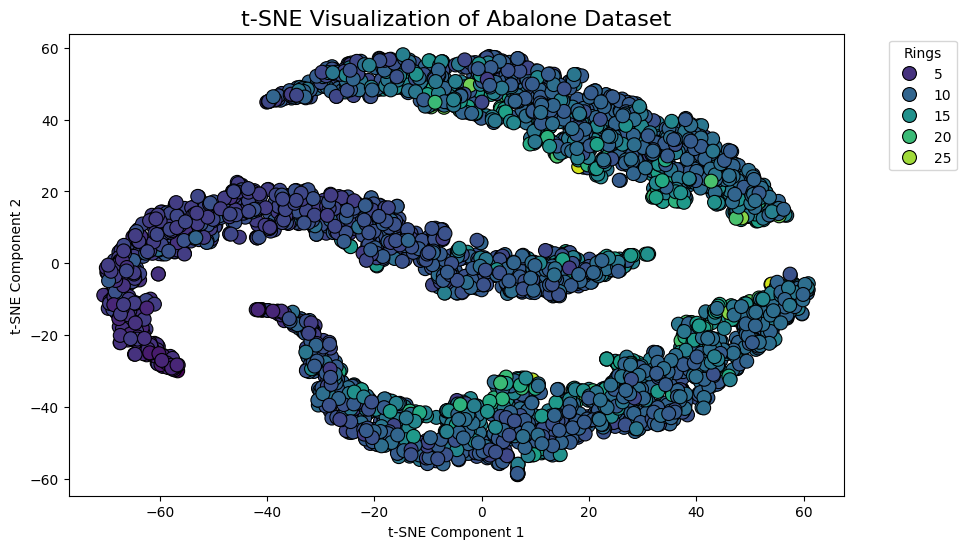

In [209]:
plot_t_sne(X_abalone, y_abalone, 'Rings', 'Abalone', perplexity=30)

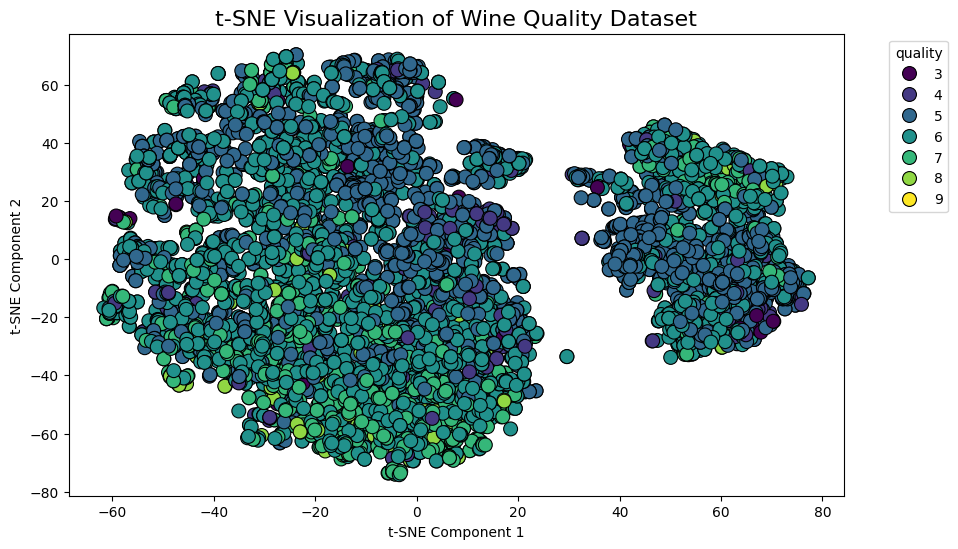

In [211]:
plot_t_sne(X_wine_quality, y_wine_qualtiy, 'quality', 'Wine Quality', perplexity=50)

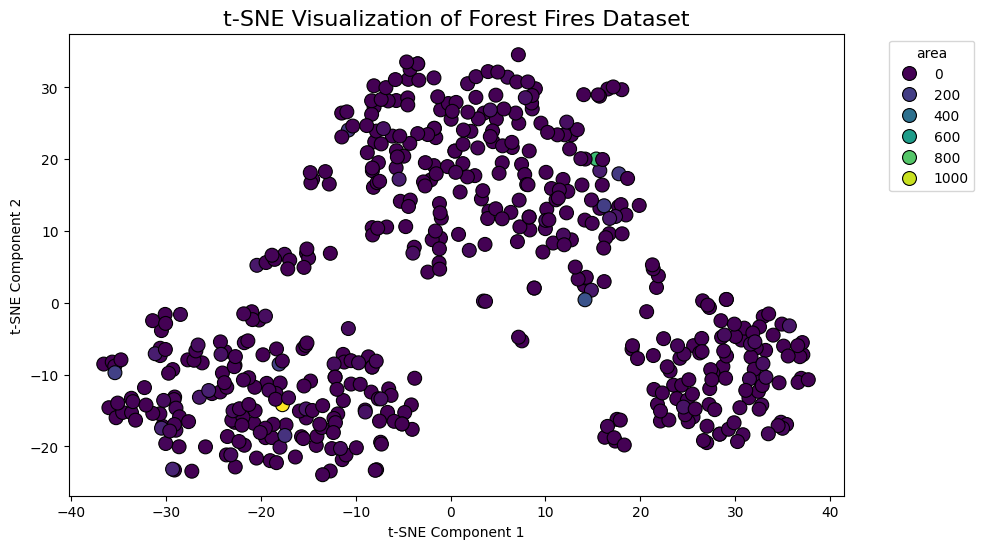

In [217]:
plot_t_sne(X_forestfires, y_forestfires, 'area', 'Forest Fires', perplexity=25)